In [1]:
# https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action#qiskit-implementation

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random
from qiskit.quantum_info import Statevector, Operator, partial_trace


# Quantum teleportation protocol

/Users/leecostello/Documents/code/lee/quantum-workbook/venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


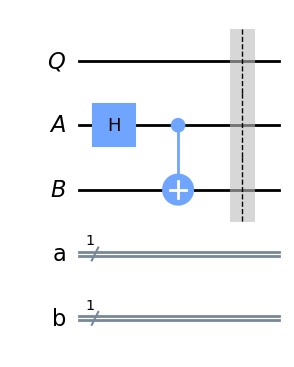

'System-wide state vector: |BAQ>'

<IPython.core.display.Latex object>

'density matrix for state of qubit B'

<IPython.core.display.Latex object>

'density matrix for state of qubit A'

<IPython.core.display.Latex object>

'density matrix for state of qubit Q'

<IPython.core.display.Latex object>

In [2]:
qubit = QuantumRegister(1, "Q") # index 2
ebit0 = QuantumRegister(1, "A") # index 1
ebit1 = QuantumRegister(1, "B") # index 0
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

def display_circuit():
  display(protocol.draw("mpl"))

  # Simulate statevector for the entire circuit
  state = Statevector.from_instruction(protocol)
  display("System-wide state vector: |BAQ>", state.draw('latex'))

  # extract statevector for qubit B
  state_b = partial_trace(state, [0, 1])
  display("density matrix for state of qubit B", state_b.draw('latex'))

  # extract statevector for qubit A
  state_a = partial_trace(state, [0, 2])
  display("density matrix for state of qubit A", state_a.draw('latex'))

  # extract statevector for qubit Q
  state_q = partial_trace(state, [1, 2])
  display("density matrix for state of qubit Q", state_q.draw('latex'))

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

display_circuit()


/Users/leecostello/Documents/code/lee/quantum-workbook/venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


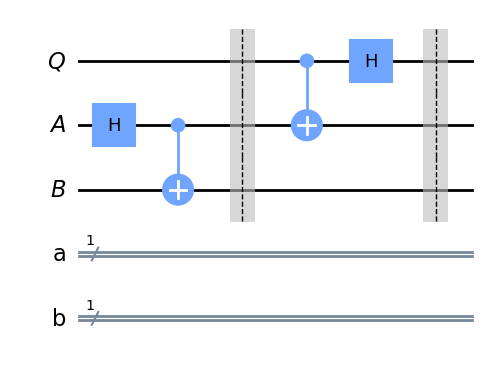

'System-wide state vector: |BAQ>'

<IPython.core.display.Latex object>

'density matrix for state of qubit B'

<IPython.core.display.Latex object>

'density matrix for state of qubit A'

<IPython.core.display.Latex object>

'density matrix for state of qubit Q'

<IPython.core.display.Latex object>

In [3]:
# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

display_circuit()


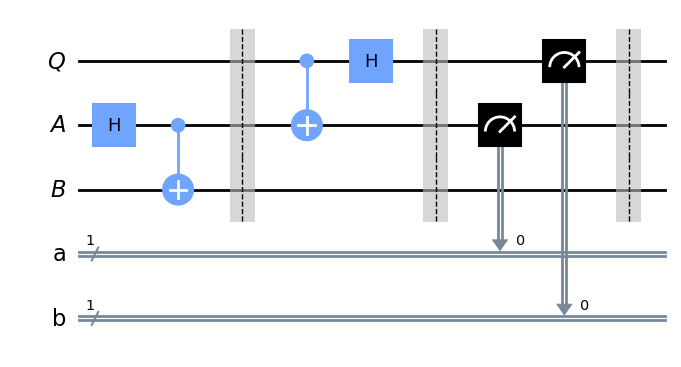

In [4]:
# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

display(protocol.draw("mpl"))

# can no longer display state vectors because measurements collapsed two of the qubits


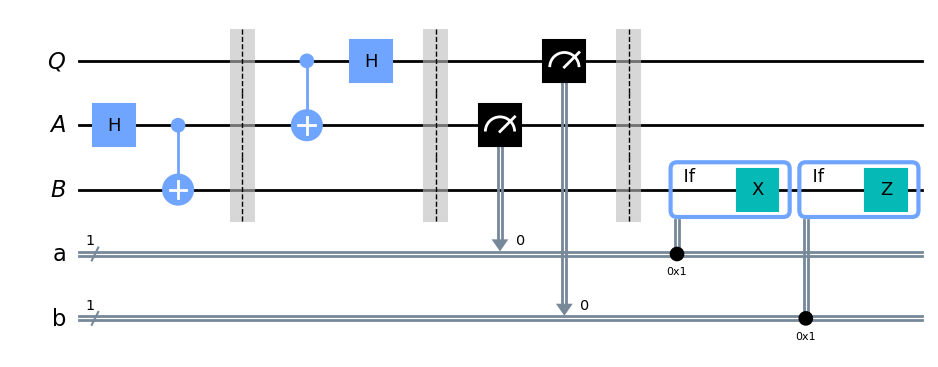

In [5]:
# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
  protocol.x(ebit1)
with protocol.if_test((b, 1)):
  protocol.z(ebit1)

display(protocol.draw("mpl"))


### test that the teleportation protocol works correctly

In [6]:
# randomly choose a unitary qubit gate
random_gate = UGate(
  theta=random.random() * 2 * pi,
  phi=random.random() * 2 * pi,
  lam=random.random() * 2 * pi
)

display(random_gate.to_matrix())


array([[-0.41281781+0.j        , -0.75872424-0.50390375j],
       [-0.82409415+0.38787922j,  0.40840517+0.06019769j]])

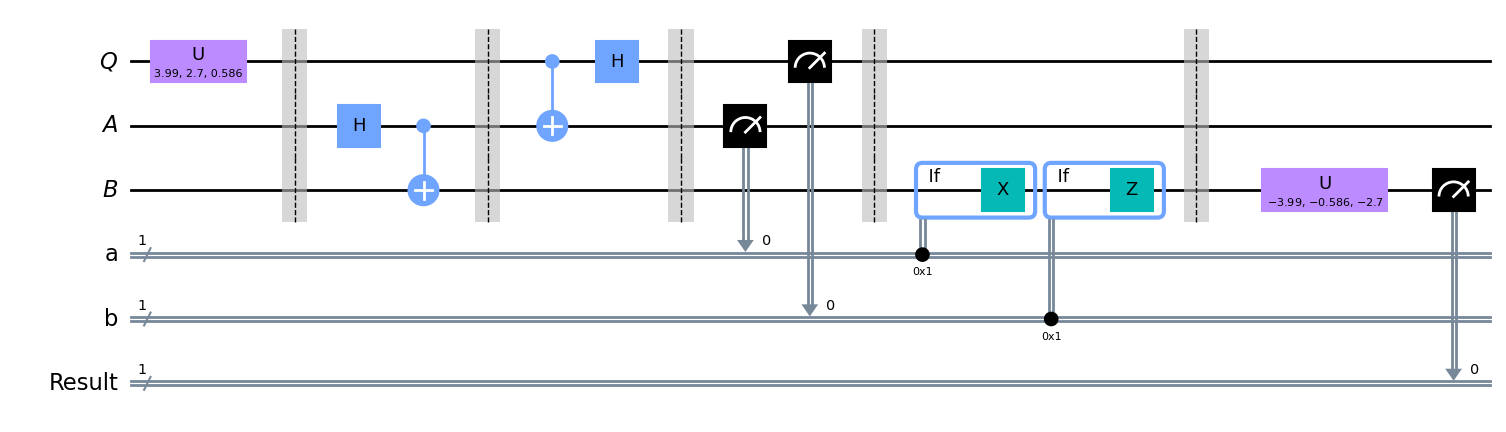

In [7]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q
test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above
test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure
test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw("mpl"))


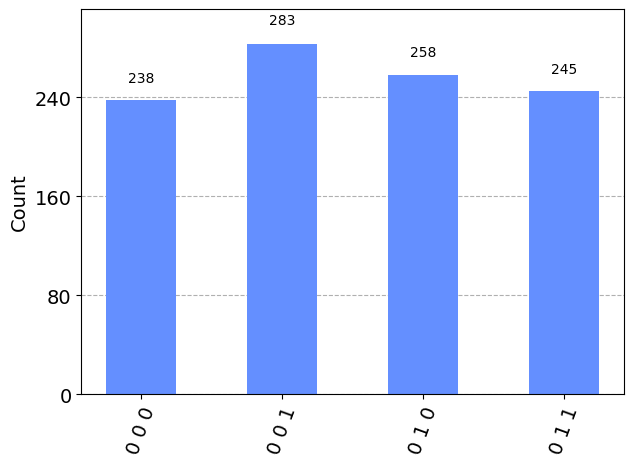

In [8]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))


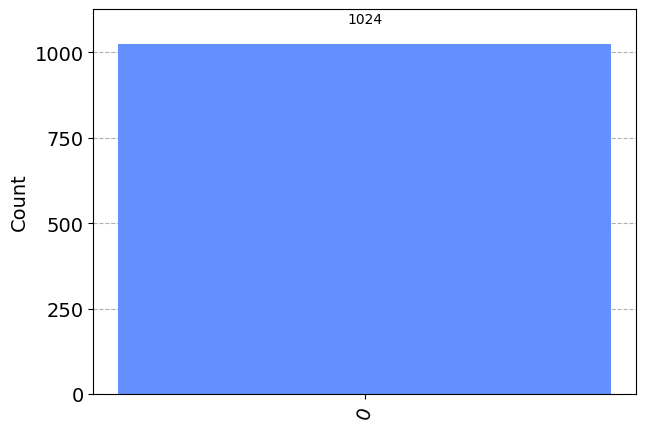

In [9]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))


# Superdense coding

In [10]:
# Required imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram


/Users/leecostello/Documents/code/lee/quantum-workbook/venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


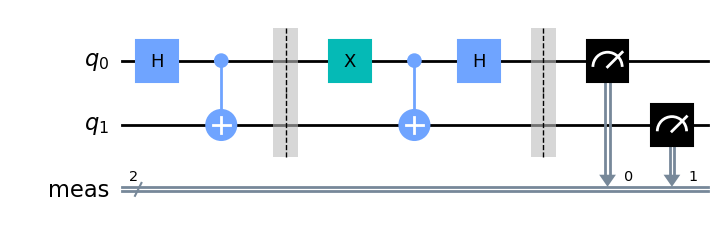

In [11]:
# bits to be transmitted
c = "1"
d = "0"

protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
  protocol.z(0)
if c == "1":
  protocol.x(0)

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw("mpl"))


Measured 10 with frequency 1.0


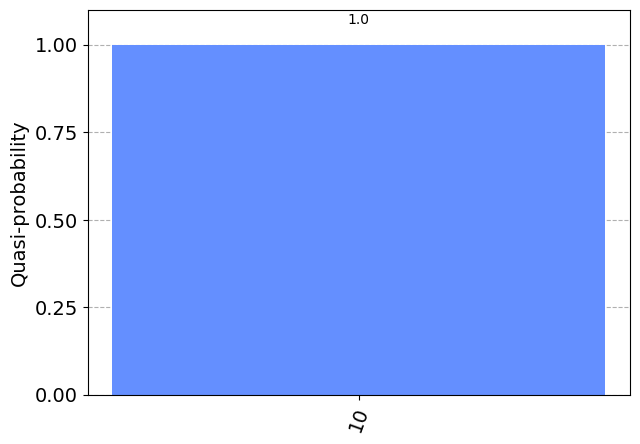

In [12]:
result = Sampler().run(protocol).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, frequency in statistics.items():
  print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))


### CHSH Game or CHSH Inequality

In [13]:
# Required imports

from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from numpy import pi
from numpy.random import randint


In [14]:
def chsh_game(strategy):
  """ Plays the CHSH Game
  Args:
    strategy (callable): A function that takes two bits (as ints) and
    returns two bits (also as ints). The strategy must follow the
    rules of the CHSH game.
  Returns:
    int: 1 for a win, 0 for a loss.
  """
  # Referee chooses x and y randomly
  x, y = randint(0, 2), randint(0, 2)

  # Use strategy to choose a and b
  a, b = strategy(x, y)

  # Referee decides if Alice an Bob win or lose
  if (a != b) == (x & y):
    return 1
  return 0


In [15]:
def chsh_circuit(x, y):
  """Creates a `QuantumCircuit` that implements the best CHSH strategy.
  Args:
    x (int): Alice's bit (must be 0 or 1)
    y (int): Bob's bit (must be 0 or 1)
  Returns:
    QuantumCircuit: Circuit that, when run, returns Alice and Bob's answer bits.
  """
  qc = QuantumCircuit(2, 2)
  qc.h(0)
  qc.cx(0, 1)
  qc.barrier()

  # Alice
  if x == 0:
    qc.ry(0, 0)
  else:
    qc.ry(-pi / 2, 0)
  qc.measure(0, 0)

  # Bob
  if y == 0:
    qc.ry(-pi / 4, 1)
  else:
    qc.ry(pi / 4, 1)
  qc.measure(1, 1)

  return qc

(x,y) = (0,0)


/Users/leecostello/Documents/code/lee/quantum-workbook/venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


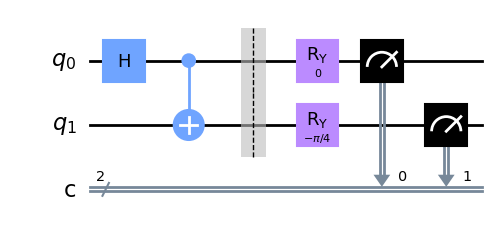

(x,y) = (0,1)


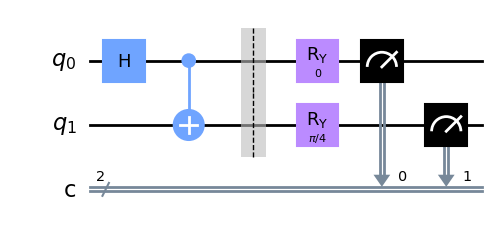

(x,y) = (1,0)


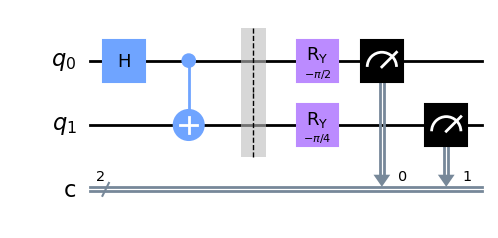

(x,y) = (1,1)


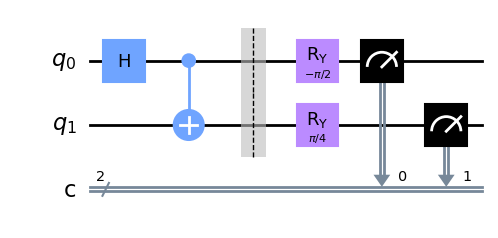

In [17]:
# Draw the four possible circuits

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw("mpl"))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw("mpl"))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw("mpl"))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw("mpl"))

In [18]:
sampler = Sampler()

def quantum_strategy(x, y):
  """Carry out the best strategy for the CHSH game.
  Args:
    x (int): Alice's bit (must be 0 or 1)
    y (int): Bob's bit (must be 0 or 1)
  Returns:
    (int, int): Alice and Bob's answer bits (respectively)
  """
  # `shots=1` runs the circuit once
  result = sampler.run(chsh_circuit(x, y), shots=1).result()
  statistics = result.quasi_dists[0].binary_probabilities()
  bits = list(statistics.keys())[0]
  a, b = bits[0], bits[1]
  return a, b

In [20]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
  TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.853
